In [ ]:
import datetime
import pandas as pd
import pandas_datareader.data as web

In [ ]:
start = datetime.datetime(2004, 8, 19) # or start = '1/1/2016'
end = datetime.date.today()
prices = web.DataReader('GOOG', 'yahoo', start, end)
print (prices.head())  # print first rows of the prices data

In [1]:
import time
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn.preprocessing as prep
from keras import backend

Using TensorFlow backend.


In [2]:
import os
s=os.getcwd()
s

'/Users/Yuffie/USA/SCU/COEN281DataMining/TermProject'

In [3]:
df = pd.read_csv('/Users/Yuffie/USA/SCU/COEN281DataMining/TermProject/data/GOOG.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,49.676899,51.693783,47.669952,49.845802,49.845802,44994500
1,2004-08-20,50.178635,54.187561,49.925285,53.805050,53.805050,23005800
2,2004-08-23,55.017166,56.373344,54.172661,54.346527,54.346527,18393200
3,2004-08-24,55.260582,55.439419,51.450363,52.096165,52.096165,15361800
4,2004-08-25,52.140873,53.651051,51.604362,52.657513,52.657513,9257400


In [4]:
# Data preparation
col_list = df.columns.tolist()
col_list

['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

In [5]:
col_list.remove('Close')
col_list.append('Close')
col_list.remove('Date')
col_list.remove('Volume')
col_list

['Open', 'High', 'Low', 'Adj Close', 'Close']

In [6]:
df = df[col_list]
df.head()

,Open,High,Low,Adj Close,Close
0,49.676899,51.693783,47.669952,49.845802,49.845802
1,50.178635,54.187561,49.925285,53.805050,53.805050
2,55.017166,56.373344,54.172661,54.346527,54.346527
3,55.260582,55.439419,51.450363,52.096165,52.096165
4,52.140873,53.651051,51.604362,52.657513,52.657513


In [7]:
# Save data
df.to_csv('GOOG-adjust.csv', index=False)
validate_df = pd.read_csv('GOOG-adjust.csv')
validate_df.head()

,Open,High,Low,Adj Close,Close
0,49.676899,51.693783,47.669952,49.845802,49.845802
1,50.178635,54.187561,49.925285,53.805050,53.805050
2,55.017166,56.373344,54.172661,54.346527,54.346527
3,55.260582,55.439419,51.450363,52.096165,52.096165
4,52.140873,53.651051,51.604362,52.657513,52.657513


In [8]:
# Standardization the dataset
def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    
    return X_train, X_test


In [9]:
# Split the data to X_train, y_train, X_test, y_test
def preprocess_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix()
    
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
        
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[: int(row), :]
    y_test_org = result[int(row) :, -1][ : ,-1]
    
    train, result = standard_scaler(train, result)
    
    X_train = train[:, : -1]
    y_train = train[:, -1][: ,-1]
    X_test = result[int(row) :, : -1]
    y_test = result[int(row) :, -1][ : ,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test, y_test_org]

In [10]:
# Build LSTM Neural Network
# LSTM --> Dropout --> LSTM --> Dropout --> Fully-Conneted(Dense)
def build_model(layers):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(LSTM(
        return_sequences=True,
        input_shape=(None, 5), units=20))
    model.add(Dropout(0.4))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.3))

    model.add(Dense(
        units=1))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [11]:
window = 20
X_train, y_train, X_test, y_test, y_test_org = preprocess_data(df[:: -1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (2993, 20, 5)
y_train (2993,)
X_test (333, 20, 5)
y_test (333,)


In [12]:
model = build_model([X_train.shape[2], window, 100, 1])

Compilation Time :  0.027528762817382812


In [13]:
# Training the model
model.fit(
    X_train,
    y_train,
    batch_size=768,
    epochs=300,
    validation_split=0.1,
    verbose=0)

In [14]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
print(model.metrics_names)
testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
print('Test Accuracy: ', testScore[1])


Train Score: 0.01 MSE (0.10 RMSE)
['loss', 'acc']
Test Score: 0.03 MSE (0.18 RMSE)
Test Accuracy:  0.0


In [15]:
#Visualize the Prediction
diff = []
ratio = []
pred = model.predict(X_test)
for u in range(len(y_test)):
    pr = pred[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))
print('error_ratio', ratio)
#print('error_abs', diff)
#print(pred)

error_ratio [0.1133188270722516, 0.12113117333001178, 0.12434312271378367, 0.11442692494278739, 0.12576963601427349, 0.11864027114397868, 0.11005930226036575, 0.075574684509538859, 0.084678743835904458, 0.10894661668503991, 0.11055392153412047, 0.056963478914290544, 0.046109114754503411, 0.066633294650770392, 0.088162016481074135, 0.10856129348853449, 0.13054266722684593, 0.1165475983346318, 0.12465535042704268, 0.13225768293636753, 0.11455260024952674, 0.12563889971341391, 0.11823949618952434, 0.14284994499788484, 0.10839947963141716, 0.090535262817867723, 0.10001035004008019, 0.10948303129434866, 0.12223594338050647, 0.11856326514441684, 0.13144598700601251, 0.15916624908582722, 0.16153487170182634, 0.14432027095464384, 0.15431753890243072, 0.13962986656818854, 0.15097689495951205, 0.22747057581207875, 0.19826187375467286, 0.19251029015459498, 0.17190272651737093, 0.17728446177315971, 0.16145640026881947, 0.14286161875122194, 0.12372685151387786, 0.10903699823435731, 0.10164919702920

In [16]:
# Scale the representation back
y_test = y_test_org
pred_org = []
for u in range(len(y_test)):
    pred_org.append(y_test[u]/(ratio[u] + 1))
    print(ratio[u])
#print(pred_org)
#print(y_test)

0.113318827072
0.12113117333
0.124343122714
0.114426924943
0.125769636014
0.118640271144
0.11005930226
0.0755746845095
0.0846787438359
0.108946616685
0.110553921534
0.0569634789143
0.0461091147545
0.0666332946508
0.0881620164811
0.108561293489
0.130542667227
0.116547598335
0.124655350427
0.132257682936
0.11455260025
0.125638899713
0.11823949619
0.142849944998
0.108399479631
0.0905352628179
0.10001035004
0.109483031294
0.122235943381
0.118563265144
0.131445987006
0.159166249086
0.161534871702
0.144320270955
0.154317538902
0.139629866568
0.15097689496
0.227470575812
0.198261873755
0.192510290155
0.171902726517
0.177284461773
0.161456400269
0.142861618751
0.123726851514
0.109036998234
0.101649197029
0.101433041313
0.105563170823
0.104627906673
0.0882872501561
0.0939810314949
0.109699869176
0.117250848493
0.0993191465743
0.0985079330926
0.0971845361938
0.106942490898
0.106605462744
0.115194293414
0.123129471771
0.128729146443
0.120646258735
0.117214952274
0.0971582441139
0.101308044633
0.1

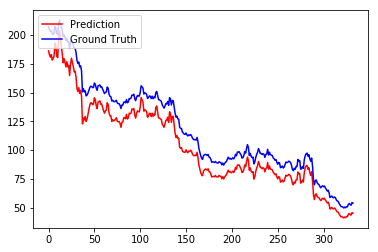

In [17]:
import matplotlib.pyplot as plt2

plt2.plot(pred_org, color='red', label='Prediction')
plt2.plot(y_test, color='blue', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()